In [1]:
# Universidad Nacional Autónoma de México
# Facultad de Ingeniería
# Reconocimiento de patrones
# 2020-1
# Aguilar Enriquez Paul Sebastian
# Ejemplo de t-SNE
# Basado en https://towardsdatascience.com/t-sne-python-example-1ded9953f26

In [2]:
import numpy as np
from sklearn.datasets import load_digits    # Dataset

# Para implementar t-SNE a mano
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform

# t-SNE implementado en sklearn
from sklearn.manifold import TSNE

# Para graficación
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [3]:
# Cargamos el dataset
X, y = load_digits(return_X_y=True)

In [4]:
# Parametros para t-SNE

## Epsilon / Learning Rate
MACHINE_EPSILON = np.finfo(np.double).eps
## Dimnesiones que tendremos
n_components = 2
## Perplejidad por default en la versión de sklearn
perplexity = 30

**Espacio de alta dimensionalidad**

t-SNE primero calcula las probabilidad p_ij que son proporionales a la similitud de los objetos x_i y x_j mediante:

![./imgs/01.png](./imgs/01.png)

La similitud de un punto x_j a un punto x_i es la probabilidad condicional p(j|i), esto es, x_i tomará x_j como su vecino.

![./imgs/02.png](./imgs/02.png)

**Grados de libertad**

Una `Student t-distribution` con un grado de libertad es lo mismo que una `Cauchy distribution` utilizada para medir similitud entre punto de baja dimensionalidad.

![./imgs/04.png](./imgs/04.png)

In [5]:
# Transforma nuestro set de datos, se apoya en la función _tsne
# que esta definida más abajo

def fit(X):
    # Almacenamos el número de muestras para futura referencia
    n_samples = X.shape[0]
    
    # Distancia euclideana
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Probabilidades conjuntas p_ij de las distancias
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # Los embeddings son inicializados con iid muetras de Gaussianos con desviación estander 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 viene de 
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [6]:
# Función _tsne implementada a mano
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    
    # Convertirmos nuestro vector en uno de 1-D
    params = X_embedded.ravel()
    
    # Generamos un objeto que procese la divergencia KL
    obj_func = _kl_divergence
    
    # Generamos un objeto que procese el gradiente descendiente
    # con los parametros definifos para el t-SNE
    # Vasicamente utilizamos nuestro gradiente para minimizar
    # la divergencia KL
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
    
    # Regresamos la transformación ya procesada pero ahora en 2D
    X_embedded = params.reshape(n_samples, n_components)
    
    return X_embedded

**Espacio de baja dimensionalidad**

Calculamos la distribución de probabilidad de los puntos del espacio de baja dimensionalidad.

![./imgs/03.png](./imgs/03.png)

En el paper se modifica el calculo añadiendo los grados de libertad (α) para la `Student-t distribution`

![./imgs/05.png](./imgs/05.png)

**Divergencia KL**

Calculamos la divergencia KL (veamos a `np.dot` como una suma.

![./imgs/06.png](./imgs/06.png)

**Gradiente (derivadas parciales)**

`dist` es yi — yj en:

![./imgs/07.png](./imgs/07.png)

Una vez más, en el paper se modifica la ecuación diferencial para incluir los grados de libertad.

![./imgs/08.png](./imgs/08.png)

In [7]:
# Implementación de la divergencia KL
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    # Calculamos Q
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Divergencia Kullback-Leibler de P y Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradiente: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    
    return kl_divergence, grad

**Gradiente descendente**

El gradiente descendente actualiza los valores de la función minimizando la divergencia KL. 

Nos detenemos cuando la norma del gradiente está por debajo del umbral o cuando alcanzamos el número máximo de iteraciones sin progresar.


In [8]:
# Definición del gradiente descendiente

def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000051
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000051
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000064
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000098
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000168
[t-SNE] Iteration 6: error = 4.0229673, gradient norm = 0.0000309
[t-SNE] Iteration 7: error = 4.0229665, gradient norm = 0.0000605
[t-SNE] Iteration 8: error = 4.0229631, gradient norm = 0.0001255
[t-SNE] Iteration 9: error = 4.0229465, gradient norm = 0.0002746
[t-SNE] Iteration 10: error = 4.0228592, gradient norm = 0.0006310
[t-SNE] Iteration 11: error = 4.0223553, gradient norm = 0.0015140
[t-SNE] Iteration 12: error = 4.0192219, gradient norm = 0.0037327
[t-SNE] Iteration 13: error = 3.9994902, gradient norm = 0.0087780
[t-SNE] Iteration 14: error = 3.9002855, gradient norm = 0.0158080
[t-SNE] Iteration 15: error = 3.6261852, gradient norm = 0.0185385
[t-S

[t-SNE] Iteration 125: error = 0.9395413, gradient norm = 0.0005680
[t-SNE] Iteration 126: error = 0.9379087, gradient norm = 0.0005807
[t-SNE] Iteration 127: error = 0.9362783, gradient norm = 0.0005577
[t-SNE] Iteration 128: error = 0.9346542, gradient norm = 0.0005492
[t-SNE] Iteration 129: error = 0.9330391, gradient norm = 0.0005103
[t-SNE] Iteration 130: error = 0.9314600, gradient norm = 0.0004899
[t-SNE] Iteration 131: error = 0.9299237, gradient norm = 0.0004834
[t-SNE] Iteration 132: error = 0.9284181, gradient norm = 0.0004650
[t-SNE] Iteration 133: error = 0.9269329, gradient norm = 0.0004465
[t-SNE] Iteration 134: error = 0.9254706, gradient norm = 0.0004392
[t-SNE] Iteration 135: error = 0.9240393, gradient norm = 0.0004351
[t-SNE] Iteration 136: error = 0.9226375, gradient norm = 0.0004320
[t-SNE] Iteration 137: error = 0.9212592, gradient norm = 0.0004544
[t-SNE] Iteration 138: error = 0.9198944, gradient norm = 0.0004709
[t-SNE] Iteration 139: error = 0.9185384, gradie

[t-SNE] Iteration 247: error = 0.8237130, gradient norm = 0.0002864
[t-SNE] Iteration 248: error = 0.8227711, gradient norm = 0.0003151
[t-SNE] Iteration 249: error = 0.8218138, gradient norm = 0.0003139
[t-SNE] Iteration 250: error = 0.8208494, gradient norm = 0.0003445
[t-SNE] Iteration 251: error = 0.8198752, gradient norm = 0.0003258
[t-SNE] Iteration 252: error = 0.8189046, gradient norm = 0.0003308
[t-SNE] Iteration 253: error = 0.8179402, gradient norm = 0.0003455
[t-SNE] Iteration 254: error = 0.8169912, gradient norm = 0.0003725
[t-SNE] Iteration 255: error = 0.8160490, gradient norm = 0.0003163
[t-SNE] Iteration 256: error = 0.8151451, gradient norm = 0.0003014
[t-SNE] Iteration 257: error = 0.8142888, gradient norm = 0.0003093
[t-SNE] Iteration 258: error = 0.8134762, gradient norm = 0.0003040
[t-SNE] Iteration 259: error = 0.8127189, gradient norm = 0.0002854
[t-SNE] Iteration 260: error = 0.8120318, gradient norm = 0.0003004
[t-SNE] Iteration 261: error = 0.8114081, gradie

[t-SNE] Iteration 369: error = 0.7733341, gradient norm = 0.0002306
[t-SNE] Iteration 370: error = 0.7729464, gradient norm = 0.0002442
[t-SNE] Iteration 371: error = 0.7725474, gradient norm = 0.0002162
[t-SNE] Iteration 372: error = 0.7721516, gradient norm = 0.0002105
[t-SNE] Iteration 373: error = 0.7717484, gradient norm = 0.0002172
[t-SNE] Iteration 374: error = 0.7713356, gradient norm = 0.0002214
[t-SNE] Iteration 375: error = 0.7709153, gradient norm = 0.0002271
[t-SNE] Iteration 376: error = 0.7704877, gradient norm = 0.0002085
[t-SNE] Iteration 377: error = 0.7700518, gradient norm = 0.0002062
[t-SNE] Iteration 378: error = 0.7696043, gradient norm = 0.0002134
[t-SNE] Iteration 379: error = 0.7691443, gradient norm = 0.0002235
[t-SNE] Iteration 380: error = 0.7686738, gradient norm = 0.0002363
[t-SNE] Iteration 381: error = 0.7681951, gradient norm = 0.0002552
[t-SNE] Iteration 382: error = 0.7677097, gradient norm = 0.0002661
[t-SNE] Iteration 383: error = 0.7672156, gradie

[t-SNE] Iteration 491: error = 0.7458179, gradient norm = 0.0000946
[t-SNE] Iteration 492: error = 0.7457035, gradient norm = 0.0000998
[t-SNE] Iteration 493: error = 0.7455896, gradient norm = 0.0001038
[t-SNE] Iteration 494: error = 0.7454757, gradient norm = 0.0000915
[t-SNE] Iteration 495: error = 0.7453629, gradient norm = 0.0000911
[t-SNE] Iteration 496: error = 0.7452508, gradient norm = 0.0000928
[t-SNE] Iteration 497: error = 0.7451391, gradient norm = 0.0000909
[t-SNE] Iteration 498: error = 0.7450281, gradient norm = 0.0000918
[t-SNE] Iteration 499: error = 0.7449177, gradient norm = 0.0000917
[t-SNE] Iteration 500: error = 0.7448082, gradient norm = 0.0000985
[t-SNE] Iteration 501: error = 0.7446992, gradient norm = 0.0001013
[t-SNE] Iteration 502: error = 0.7445905, gradient norm = 0.0000927
[t-SNE] Iteration 503: error = 0.7444823, gradient norm = 0.0000852
[t-SNE] Iteration 504: error = 0.7443750, gradient norm = 0.0000923
[t-SNE] Iteration 505: error = 0.7442679, gradie

[t-SNE] Iteration 613: error = 0.7344387, gradient norm = 0.0000864
[t-SNE] Iteration 614: error = 0.7343327, gradient norm = 0.0000903
[t-SNE] Iteration 615: error = 0.7342237, gradient norm = 0.0000909
[t-SNE] Iteration 616: error = 0.7341110, gradient norm = 0.0000904
[t-SNE] Iteration 617: error = 0.7339932, gradient norm = 0.0000896
[t-SNE] Iteration 618: error = 0.7338703, gradient norm = 0.0000929
[t-SNE] Iteration 619: error = 0.7337410, gradient norm = 0.0001020
[t-SNE] Iteration 620: error = 0.7336032, gradient norm = 0.0001140
[t-SNE] Iteration 621: error = 0.7334524, gradient norm = 0.0001238
[t-SNE] Iteration 622: error = 0.7332860, gradient norm = 0.0001170
[t-SNE] Iteration 623: error = 0.7331081, gradient norm = 0.0001176
[t-SNE] Iteration 624: error = 0.7329240, gradient norm = 0.0001215
[t-SNE] Iteration 625: error = 0.7327516, gradient norm = 0.0000952
[t-SNE] Iteration 626: error = 0.7326624, gradient norm = 0.0001025
[t-SNE] Iteration 627: error = 0.7326798, gradie

[t-SNE] Iteration 735: error = 0.7267044, gradient norm = 0.0000549
[t-SNE] Iteration 736: error = 0.7266593, gradient norm = 0.0000547
[t-SNE] Iteration 737: error = 0.7266143, gradient norm = 0.0000595
[t-SNE] Iteration 738: error = 0.7265694, gradient norm = 0.0000665
[t-SNE] Iteration 739: error = 0.7265246, gradient norm = 0.0000760
[t-SNE] Iteration 740: error = 0.7264798, gradient norm = 0.0000730
[t-SNE] Iteration 741: error = 0.7264351, gradient norm = 0.0000666
[t-SNE] Iteration 742: error = 0.7263905, gradient norm = 0.0000599
[t-SNE] Iteration 743: error = 0.7263464, gradient norm = 0.0000637
[t-SNE] Iteration 744: error = 0.7263023, gradient norm = 0.0000678
[t-SNE] Iteration 745: error = 0.7262582, gradient norm = 0.0000628
[t-SNE] Iteration 746: error = 0.7262144, gradient norm = 0.0000613
[t-SNE] Iteration 747: error = 0.7261706, gradient norm = 0.0000574
[t-SNE] Iteration 748: error = 0.7261271, gradient norm = 0.0000616
[t-SNE] Iteration 749: error = 0.7260836, gradie

[t-SNE] Iteration 857: error = 0.7220400, gradient norm = 0.0000503
[t-SNE] Iteration 858: error = 0.7220077, gradient norm = 0.0000487
[t-SNE] Iteration 859: error = 0.7219755, gradient norm = 0.0000540
[t-SNE] Iteration 860: error = 0.7219432, gradient norm = 0.0000519
[t-SNE] Iteration 861: error = 0.7219110, gradient norm = 0.0000525
[t-SNE] Iteration 862: error = 0.7218787, gradient norm = 0.0000497
[t-SNE] Iteration 863: error = 0.7218463, gradient norm = 0.0000525
[t-SNE] Iteration 864: error = 0.7218138, gradient norm = 0.0000498
[t-SNE] Iteration 865: error = 0.7217810, gradient norm = 0.0000480
[t-SNE] Iteration 866: error = 0.7217482, gradient norm = 0.0000509
[t-SNE] Iteration 867: error = 0.7217153, gradient norm = 0.0000499
[t-SNE] Iteration 868: error = 0.7216825, gradient norm = 0.0000468
[t-SNE] Iteration 869: error = 0.7216502, gradient norm = 0.0000500
[t-SNE] Iteration 870: error = 0.7216182, gradient norm = 0.0000499
[t-SNE] Iteration 871: error = 0.7215866, gradie

[t-SNE] Iteration 979: error = 0.7185244, gradient norm = 0.0000422
[t-SNE] Iteration 980: error = 0.7184989, gradient norm = 0.0000438
[t-SNE] Iteration 981: error = 0.7184734, gradient norm = 0.0000436
[t-SNE] Iteration 982: error = 0.7184480, gradient norm = 0.0000437
[t-SNE] Iteration 983: error = 0.7184226, gradient norm = 0.0000436
[t-SNE] Iteration 984: error = 0.7183972, gradient norm = 0.0000430
[t-SNE] Iteration 985: error = 0.7183718, gradient norm = 0.0000456
[t-SNE] Iteration 986: error = 0.7183464, gradient norm = 0.0000448
[t-SNE] Iteration 987: error = 0.7183210, gradient norm = 0.0000480
[t-SNE] Iteration 988: error = 0.7182957, gradient norm = 0.0000511
[t-SNE] Iteration 989: error = 0.7182704, gradient norm = 0.0000516
[t-SNE] Iteration 990: error = 0.7182449, gradient norm = 0.0000446
[t-SNE] Iteration 991: error = 0.7182196, gradient norm = 0.0000459
[t-SNE] Iteration 992: error = 0.7181943, gradient norm = 0.0000468
[t-SNE] Iteration 993: error = 0.7181691, gradie

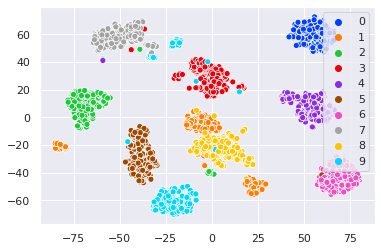

In [9]:
# Tenemos todo listo, usemoslo!
X_embedded = fit(X)

# Grafiquemos
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

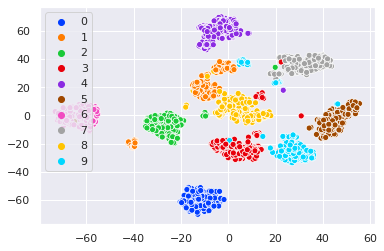

In [10]:
# Veamos la versión ya implementada e.e
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
# Grafiquemos
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)